<a href="https://colab.research.google.com/github/yurikobyzev/yurikobyzev/blob/main/iris_multiset_vits16_dino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!! pip install open-metric-learning
!! pip install pytorch-metric-learning
!! pip install pillow==9.0.0

In [ ]:
%cd /content/drive/MyDrive/iris

/content/drive/MyDrive/iris


In [ ]:
import oml
print(oml.__version__)
from oml.models.meta.siamese import ConcatSiamese

0.3.14


In [ ]:
import torch
from tqdm import tqdm

from oml.datasets.base import DatasetWithLabels
from oml.losses.triplet import TripletLossWithMiner
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.models.vit.vit import ViTExtractor
from oml.samplers.balance import BalanceSampler
from oml.datasets.base import DatasetQueryGallery
from oml.metrics.embeddings import EmbeddingMetrics
from oml.utils.dataframe_format import check_retrieval_dataframe_format
from oml.utils.misc_torch import PCA
from oml.inference.flat import inference_on_images
from oml.registry.transforms import get_transforms_for_pretrained
from oml.utils.misc_torch import pairwise_dist
from pytorch_metric_learning import losses, distances, reducers, miners
import pandas as pd
from oml.transforms.images.torchvision import get_normalisation_resize_torch
from oml.models.meta.siamese import ConcatSiamese
from oml.miners.pairs import PairsMiner
from oml.inference.flat import inference_on_dataframe
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from oml.retrieval.postprocessors.pairwise import PairwiseImagesPostprocessor
from pprint import pprint



In [ ]:
import pandas as pd
from pathlib import Path
import pathlib

iris_path='/content/drive/MyDrive/iris'
iris_path=pathlib.PosixPath(iris_path)


root_iris_id='iris_dataset'
iris_id_csv="/content/drive/MyDrive/iris/df_iris_dataset_LR.csv"

root_iris_amf='AMF_Iris_Dataset'
iris_amf='/content/drive/MyDrive/iris/AMF_Iris_Dataset'
iris_amf_csv='/content/drive/MyDrive/iris/df_amf_LR.csv'

root_iris_mmu ='MMU-Iris-Database'
iris_mmu ='/content/drive/MyDrive/iris/MMU-Iris-Database'
iris_mmu_csv = '/content/drive/MyDrive/iris/df_mmu_LR.csv'

# open metric learning format for datasets and pipelines...
df_iris_id = pd.read_csv(iris_id_csv)
df_iris_mmu = pd.read_csv(iris_mmu_csv)
df_iris_amf = pd.read_csv(iris_amf_csv)

In [ ]:
df_iris_mmu

<H3>Формируем датафреймы с 3мя базами

In [ ]:
header="label,src_file,split,is_query,is_gallery,eye,ds,path"

In [ ]:

!ls {iris_mmu}

1   12	15  18	20  23	26  29	31  34	37  40	43  46	7  ReadMe.txt
10  13	16  19	21  24	27  3	32  35	38  41	44  5	8
11  14	17  2	22  25	28  30	33  36	39  42	45  6	9


In [ ]:
!ls {iris_amf}

aadil  ameer   ayad    elaf   israa    mahmood	omar   saldar	wisam
abas   ameina  azam    fars   kamal    maria	rafa   sirag	yaseen
abeer  anas    aziz    fuaad  kareem   marwan	rasha  sundos	zafer
adnan  arwa    basam   ghazi  khaleel  mazin	saad   tabarak	zahraa
ahmed  asmaa   baydaa  hamza  khalid   mohamad	saadi  taha	zaid
ali    assem   daood   huda   loai     muhand	salam  wathah	zakaria


<H3>MMU

In [ ]:
from os import walk

labels_mmu = []
print(iris_mmu)
for (dirpath, dirnames, filenames) in walk(iris_mmu):
  print(dirnames)
  labels_mmu.extend(dirnames)
  break

mmulabels=[i for i in range(len(labels_mmu))]   
print(labels_mmu)
print(mmulabels)

/content/drive/MyDrive/iris/MMU-Iris-Database
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '5', '6', '7', '8', '9']
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '5', '6', '7', '8', '9']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


In [ ]:
from os import walk

labels_amf = []
print(iris_amf)
for (dirpath, dirnames, filenames) in walk(iris_amf):
  print(dirnames)
  labels_amf.extend(dirnames)
  break
print(labels_amf)
amflabels=[i for i in range(len(labels_amf))]    

In [ ]:
from os import walk
import pandas as pd
 
# Create a sample DataFrame
data = {'label': [],
        'src_file': [],
        'split': [],
        'is_query': [],        
        'is_gallery': [],
        'eye': [],
        'ds': [],
        'path': []
        }
df_mmu = pd.DataFrame(data)
 


is_query=1
is_gallery=0.0
for mmu_lab,label in zip(labels_mmu, mmulabels):
  lr='L'
  path=iris_mmu+'/'+mmu_lab+'/left'
  for (dirpath, dirnames, filenames) in walk(path):
    for filename in (filenames):
      fpath=root_iris_mmu+'/'+mmu_lab+'/left/'+filename
      fn,ext = filename.split('.')
      print(fn,ext)
      if ext!='bmp':
        break

      if (is_query==1.0):
         is_query=0.0
         is_gallery=1.0
      else:
         is_query=1.0
         is_gallery=0.0 


      new_row = {'label': label, 
             'src_file': filename, 
             'split': 'validation',
             'is_query': is_query, 
             'is_gallery': is_gallery,
             'eye': lr,
             'ds': 'mmu',
             'path': fpath
             }

      df_mmu.loc[len(df_mmu)] = new_row           
  

In [ ]:
is_query=1
is_gallery=0.0
for mmu_lab,label in zip(labels_mmu, mmulabels):
  lr='R'
  path=iris_mmu+'/'+mmu_lab+'/right'
  for (dirpath, dirnames, filenames) in walk(path):
    for filename in (filenames):
      fpath=root_iris_mmu+'/'+mmu_lab+'/right/'+filename
      fn,ext = filename.split('.')
      print(fn,ext)
      if ext!='bmp':
        break

      if (is_query==1.0):
         is_query=0.0
         is_gallery=1.0
      else:
         is_query=1.0
         is_gallery=0.0 


      new_row = {'label': label, 
             'src_file': filename, 
             'split': 'validation',
             'is_query': is_query, 
             'is_gallery': is_gallery,
             'eye': lr,
             'ds': 'mmu',
             'path': fpath
             }

      df_mmu.loc[len(df_mmu)] = new_row     

In [ ]:
df_mmu.sort_values(by=['eye','label'], inplace=True)

In [ ]:
df_mmu.to_csv(iris_mmu_csv,index=False)

In [ ]:
df_mmu

,label,src_file,split,is_query,is_gallery,eye,ds,path
0,1,fional3.bmp,validation,0.0,1.0,L,mmu,MMU-Iris-Database/10/left/fional3.bmp
1,1,fional2.bmp,validation,1.0,0.0,L,mmu,MMU-Iris-Database/10/left/fional2.bmp
2,1,fional5.bmp,validation,0.0,1.0,L,mmu,MMU-Iris-Database/10/left/fional5.bmp
3,2,hockl2.bmp,validation,1.0,0.0,L,mmu,MMU-Iris-Database/11/left/hockl2.bmp
4,2,hockl5.bmp,validation,0.0,1.0,L,mmu,MMU-Iris-Database/11/left/hockl5.bmp
...,...,...,...,...,...,...,...,...
423,44,fatmar3.bmp,validation,1.0,0.0,R,mmu,MMU-Iris-Database/9/right/fatmar3.bmp
424,44,fatmar1.bmp,validation,0.0,1.0,R,mmu,MMU-Iris-Database/9/right/fatmar1.bmp
425,44,fatmar4.bmp,validation,1.0,0.0,R,mmu,MMU-Iris-Database/9/right/fatmar4.bmp
426,44,fatmar2.bmp,validation,0.0,1.0,R,mmu,MMU-Iris-Database/9/right/fatmar2.bmp


<h3>AMF

In [ ]:
from os import walk
import pandas as pd
 
# Create a sample DataFrame
data = {'label': [],
        'src_file': [],
        'split': [],
        'is_query': [],        
        'is_gallery': [],
        'eye': [],
        'ds': [],
        'path': []
        }
df_amf = pd.DataFrame(data)
 


is_query=1
is_gallery=0.0
for amf_lab,label in zip(labels_amf, amflabels):
  path=iris_amf+'/'+amf_lab
  for (dirpath, dirnames, filenames) in walk(path):
    for filename in (filenames):
      fpath=root_iris_amf+'/'+amf_lab+'/'+filename
      fn,ext = filename.split('.')
      print(fn,ext)
      if ext!='bmp':
        next
        try:
          iris, fdate, ftime, lr = fn.split('_')
        except:
          iris, fdate, ftime, lr, _ = fn.split('_')   
      if (lr=='Left'):
        lr='L'
      else:
        lr='R'

      if (is_query==1.0):
         is_query=0.0
         is_gallery=1.0
      else:
         is_query=1.0
         is_gallery=0.0 


      new_row = {'label': label, 
             'src_file': filename, 
             'split': 'validation',
             'is_query': is_query, 
             'is_gallery': is_gallery,
             'eye': lr,
             'ds': 'amf',
             'path': fpath
             }

      df_amf.loc[len(df_amf)] = new_row           
  


In [ ]:
df_amf.sort_values(by=['eye','label'], inplace=True)



In [ ]:
df_amf.to_csv(iris_amf_csv,index=False)

In [ ]:
df_amf

,label,src_file,split,is_query,is_gallery,eye,ds,path
0,0,Iris_20220818_122818_Right.bmp,validation,0.0,1.0,R,amf,AMF_Iris_Dataset/aadil/Iris_20220818_122818_Ri...
1,0,Iris_20220818_122827_Left.bmp,validation,1.0,0.0,R,amf,AMF_Iris_Dataset/aadil/Iris_20220818_122827_Le...
2,0,Iris_20220818_122821_Right.bmp,validation,0.0,1.0,R,amf,AMF_Iris_Dataset/aadil/Iris_20220818_122821_Ri...
3,0,Iris_20220818_122825_Right.bmp,validation,1.0,0.0,R,amf,AMF_Iris_Dataset/aadil/Iris_20220818_122825_Ri...
4,0,Iris_20220818_122825_Left.bmp,validation,0.0,1.0,R,amf,AMF_Iris_Dataset/aadil/Iris_20220818_122825_Le...
...,...,...,...,...,...,...,...,...
535,53,Iris_20220818_122409_Right.bmp,validation,1.0,0.0,R,amf,AMF_Iris_Dataset/zakaria/Iris_20220818_122409_...
536,53,Iris_20220818_122413_Right.bmp,validation,0.0,1.0,R,amf,AMF_Iris_Dataset/zakaria/Iris_20220818_122413_...
537,53,Iris_20220818_122416_Left.bmp,validation,1.0,0.0,R,amf,AMF_Iris_Dataset/zakaria/Iris_20220818_122416_...
538,53,Iris_20220818_122416_Right.bmp,validation,0.0,1.0,R,amf,AMF_Iris_Dataset/zakaria/Iris_20220818_122416_...


<H3> Iris_id dataset

In [ ]:
iris_dataset_path='/content/drive/MyDrive/iris/iris_dataset'

In [ ]:
#columns=['label','path','split','is_query', 'is_gallery','category','x_1','x_2','y_1','y_2']

In [ ]:
#csvpath="/content/drive/MyDrive/iris/iris_id.cs
csvpath="/content/drive/MyDrive/iris/df_iris_dataset_LR.csv"
iris_dataset_csvpath = csvpath



RE for iris_rf 

In [ ]:
# import iris_id dataset
import os

# folder path
#dir_path = iris_id_path
dir_path=iris_dataset_path
print(dir_path)

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)

###############################################
header="label,src_file,split,is_query,is_gallery,eye,ds,path"
print(csvpath)
with open(csvpath, 'w') as f:
  f.write(header)
  f.write('\n')
  for i in range(len(res)):
    path=res[i]
    print(path)
    a,ext=path.split('.')
    path='iris_dataset/'+path
    l1,n=a.split('_')
    #l1,n,ext=path.split('_') # iris_rf
    src_file=l1+'_'+n
    n=int(n)
    label=str(int(l1[0:len(l1)-1])-1)
    lr=l1[-1:]
    f.write(label)
    f.write(',')
    f.write(src_file)
    f.write(',')
    if (n<2):
      f.write('train,')
      f.write(",") 
    else:  
       f.write('validation,')
       f.write('1,1') 
    f.write(',')  
    f.write(lr) 
    f.write(',')  
    #f.write('iris_rf')
    f.write('iris_idt')
    f.write(',')  
    f.write(path)  
    f.write('\n')

In [ ]:
# import iris_id dataset
from os import walk
import pandas as pd
import os

# folder path
#dir_path = iris_id_path
dir_path=iris_dataset_path
print(dir_path)

# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)

###############################################
header="label,src_file,split,is_query,is_gallery,eye,ds,path"

# Create a sample DataFrame
data = {'label': [],
        'src_file': [],
        'split': [],
        'is_query': [],        
        'is_gallery': [],
        'eye': [],
        'ds': [],
        'path': []
        }
df_iris = pd.DataFrame(data)

for i in range(len(res)):
  path=res[i]
  print(path)
  a,ext=path.split('.')
  fpath='iris_dataset/'+path
  l1,n=a.split('_')
  src_file=l1+'_'+n
  n=int(n)
  label=str(int(l1[0:len(l1)-1])-1)
  lr=l1[-1:]
  if (n<2):
    split='train'
    is_query=None
    is_gallery=None
  else:
    split='validation'  
    is_query=1.0
    is_gallery=1.0
  new_row = {'label': label, 
           'src_file': src_file, 
           'split': split,
           'is_query': is_query, 
           'is_gallery': is_gallery,
           'eye': lr,
           'ds': 'iris_id',
           'path': fpath
           }

  df_iris.loc[len(df_iris)] = new_row    


In [ ]:

df_iris.sort_values(by=['eye','label'], inplace=True)
df=df_iris

In [ ]:
df_iris

,label,src_file,split,is_query,is_gallery,eye,ds,path
0,0,001L_1,train,NaN,NaN,L,iris_id,iris_dataset/001L_1.png
1,0,001L_2,validation,1.0,1.0,L,iris_id,iris_dataset/001L_2.png
3,0,001L_3,validation,1.0,1.0,L,iris_id,iris_dataset/001L_3.png
6,1,002L_1,train,NaN,NaN,L,iris_id,iris_dataset/002L_1.png
7,1,002L_2,validation,1.0,1.0,L,iris_id,iris_dataset/002L_2.png
...,...,...,...,...,...,...,...,...
52,8,009R_1,train,NaN,NaN,R,iris_id,iris_dataset/009R_1.png
53,8,009R_3,validation,1.0,1.0,R,iris_id,iris_dataset/009R_3.png
57,9,010R_1,train,NaN,NaN,R,iris_id,iris_dataset/010R_1.png
58,9,010R_3,validation,1.0,1.0,R,iris_id,iris_dataset/010R_3.png


<H3> Разбиваем Iris Id на 1/3 - train
1/3 validation query (запросы)
1/3 validation gallery (ответы в которых ищутся запросы)
на запрос для метрики нужен хотя б один ответ с той же меткой
но для инференса не обязательно
<p>
Я не стал одинаковые файлы оставлять и в запросах и ответах иначе это слишком легко
у нас если левый глаз найдет снимок другого левого или правого глаза того же человека - это цель!

In [ ]:
df_val=df[df['split']=='validation']
for i in range(64):
  dfl=df_val[df_val['label']==i]
  L=dfl[dfl['eye']=='L']
  l=len(L)
  k=0
  for j in L.index:
    if (k<l//2):
      # print('set 1,0',j)
      df.loc[j,'is_query']=1.0
      df.loc[j,'is_gallery']=0.0  
      k+=1
    else:
      df.loc[j,'is_query']=0.0
      df.loc[j,'is_gallery']=1.0
      k+=1    

  R=dfl[dfl['eye']=='R']
  r=len(R)
  k=0
  for j in R.index:
    if (k<r//2):
      # print('set 1,0',j)
      df.loc[j,'is_query']=1.0
      df.loc[j,'is_gallery']=0.0  
      k+=1
    else:
      df.loc[j,'is_query']=0.0
      df.loc[j,'is_gallery']=1.0
      k+=1    
  



In [ ]:
df

,label,src_file,split,is_query,is_gallery,eye,ds,path
0,0,001L_1,train,NaN,NaN,L,iris_id,iris_dataset/001L_1.png
1,0,001L_2,validation,1.0,0.0,L,iris_id,iris_dataset/001L_2.png
2,0,001L_3,validation,0.0,1.0,L,iris_id,iris_dataset/001L_3.png
3,1,002L_1,train,NaN,NaN,L,iris_id,iris_dataset/002L_1.png
4,1,002L_2,validation,1.0,0.0,L,iris_id,iris_dataset/002L_2.png
...,...,...,...,...,...,...,...,...
379,8,009R_1,train,NaN,NaN,R,iris_id,iris_dataset/009R_1.png
380,8,009R_3,validation,0.0,1.0,R,iris_id,iris_dataset/009R_3.png
381,9,010R_1,train,NaN,NaN,R,iris_id,iris_dataset/010R_1.png
382,9,010R_3,validation,1.0,0.0,R,iris_id,iris_dataset/010R_3.png


In [ ]:
csvpath

'/content/drive/MyDrive/iris/df_iris_dataset_LR.csv'

In [ ]:
df.to_csv(csvpath,index=False)
df = pd.read_csv(csvpath)

In [ ]:
df_iris = pd.read_csv(csvpath)

In [ ]:
df_iris

,label,src_file,split,is_query,is_gallery,eye,ds,path
0,0,001L_1,train,NaN,NaN,L,iris_id,iris_dataset/001L_1.png
1,0,001L_2,validation,1.0,0.0,L,iris_id,iris_dataset/001L_2.png
2,0,001L_3,validation,0.0,1.0,L,iris_id,iris_dataset/001L_3.png
3,1,002L_1,train,NaN,NaN,L,iris_id,iris_dataset/002L_1.png
4,1,002L_2,validation,1.0,0.0,L,iris_id,iris_dataset/002L_2.png
...,...,...,...,...,...,...,...,...
379,8,009R_1,train,NaN,NaN,R,iris_id,iris_dataset/009R_1.png
380,8,009R_3,validation,0.0,1.0,R,iris_id,iris_dataset/009R_3.png
381,9,010R_1,train,NaN,NaN,R,iris_id,iris_dataset/010R_1.png
382,9,010R_3,validation,1.0,0.0,R,iris_id,iris_dataset/010R_3.png


save is_query is_gallery

<h3> Теперь берем предобученную на огромном датасете (что то из торговли) модель для эмбеддингов и тренируем ее 1 эпоху (больше не надо!) на iris_id train

In [ ]:
model_types=['vits16_dino', 'vits8_dino', 'vitb16_dino', 'vitb8_dino', 'vits16_inshop', 'vits16_sop', 'vits16_cub', 'vits16_cars']
modeltype='vits16_dino'
arch='vits16'

In [ ]:
device = torch.device("cuda")

<H3> Валидность датасета проверяется тут 

In [ ]:
from pathlib import Path
from oml.utils.dataframe_format import check_retrieval_dataframe_format
p=Path(iris_path)

check_retrieval_dataframe_format(df=pd.read_csv(csvpath), dataset_root=p)

In [ ]:
p

PosixPath('/content/drive/MyDrive/iris')

In [ ]:
check_retrieval_dataframe_format(df=df_amf, dataset_root=p)

Восстановим модель с диска по весам для инференса? Тогда обучение пропускаем

In [ ]:
# для левой модели хорошее предсказание для amf - 3%]
#modelpath='/content/drive/MyDrive/iris/iris_dataset_LR1.pt'
#model=ViTExtractor(weights=modelpath,arch=arch, normalise_features=False)
#model.eval()

<H3>Обучение с нуля (но предобученные веса загружаются автоматом)

Triple loss on embeddings

In [ ]:
im_size=128 # меньше не стоит
threshold=200 # порог пеохоже не важен - можно и 0.4 как было вначале взять
transform = get_normalisation_resize_torch(im_size=im_size)

<H3>одна эпоха

In [ ]:
# тут НЕ сохраненные на зрачках веса грузятся
model = ViTExtractor(modeltype, arch=arch, normalise_features=False).train()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
transform = get_normalisation_resize_torch(im_size=im_size)
train_dataset = DatasetWithLabels(df, dataset_root=p,transform=transform)
device = torch.device("cuda")
model.to(device)

# PML specific
distance = distances.LpDistance(p=2)
reducer = reducers.ThresholdReducer(low=0)
criterion = losses.TripletMarginLoss()
miner = miners.TripletMarginMiner(margin=threshold, distance=distance, type_of_triplets="hard")

sampler = BalanceSampler(train_dataset.get_labels(), n_labels=2, n_instances=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler)

# Одна эпоха потом посмотрим когда метрики построим может и еще надо 
n_epoch=1

for i in range(n_epoch):
  for batch in tqdm(train_loader): 
    embeddings = model(batch["input_tensors"].to(device))
    loss = criterion(embeddings, batch["labels"], miner(embeddings, batch["labels"]))  # PML specific
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    

    

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth
Checkpoint is already here.


100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


<h3>еще 30 эпох (в наем случае улучшать нечего)

In [ ]:
# это не пригодилось - потренировать - итак хорошая метрика
n_epoch=30

for i in range(n_epoch):
  for batch in tqdm(train_loader): 
    embeddings = model(batch["input_tensors"].to(device))
    loss = criterion(embeddings, batch["labels"], miner(embeddings, batch["labels"]))  # PML specific
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 32/32 [00:03<00:00,  8.49it/s]


<H3> По слегка оттренированной
 модели смотрим какие метрики в валидации получились
 в калькуляторе

In [ ]:
miner = miners.TripletMarginMiner(margin=threshold, distance=distance, type_of_triplets="all")

In [ ]:
# создаем калькулятор метрик, в котором будем накапливать вектора

val_dataset = DatasetQueryGallery(df, dataset_root=p,transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4)

calculator = EmbeddingMetrics(map_top_k=(5,3,2,1),cmc_top_k =(5,3,2,1),precision_top_k =(5,3,2,1) )
calculator.setup(num_samples=len(train_dataset))

with torch.no_grad():
    for batch in tqdm(val_loader):
        batch["embeddings"] = model(batch["input_tensors"].to(device))
        calculator.update_data(batch)  # накапливаем вектора



100%|██████████| 96/96 [00:09<00:00, 10.37it/s]


In [ ]:
metrics = calculator.compute_metrics()  # вычисляем метрики: cmc@k, precision@k, map@k


Metrics:
{'OVERALL': {'cmc': {1: tensor(0.9961),
                     2: tensor(0.9961),
                     3: tensor(1.),
                     5: tensor(1.)},
             'map': {1: tensor(0.9961),
                     2: tensor(0.9961),
                     3: tensor(0.9915),
                     5: tensor(0.9724)},
             'pcf': {0.5: tensor(0.0104)},
             'precision': {1: tensor(0.9961),
                           2: tensor(0.9551),
                           3: tensor(0.8893),
                           5: tensor(0.9007)}}}


<H3> Метрики свиду ОТЛИЧНЫЕ - спасибо за веса автору

<h3>Сохраним веса (по факту обучение на iris_id причем лишь на 1/3 train) и в дальнейшем инференс запускаем с нее

In [ ]:
#modelpathLR='/content/drive/MyDrive/iris/iris_dataset_LR1.pt'
#torch.save(model.state_dict(), modelpathLR)


<H3> Inference на AMF (про нее модель ничего не знает) В самом датасете все помечено как validation и разбито на query (test) / gallery - база уже имеющихся фото

In [ ]:
df=df_amf

In [ ]:
# Смысл такой что по запросам query мы ищем ближайший (похоже 1) 
# но только среди элементов gallery
queries=[]
df_val=df[df['split']=='validation']
lquery=df_val[df_val["is_query"]==1.0]["label"].tolist()
lgallery=df_val[df_val["is_gallery"]==1.0]["label"].tolist()
squeries = df_val[df_val["is_query"]==1.0]["path"].tolist()
sgalleries = df_val[df_val["is_gallery"]==1.0]["path"].tolist()

df_val["path"] = df_val["path"].apply(lambda x: pamf / x)

queries = df_val[df_val["is_query"]==1.0]["path"].tolist()
galleries = df_val[df_val["is_gallery"]==1.0]["path"].tolist()

#queries.extend(df_new["path"].values) 
####transform, _ = get_transforms_for_pretrained(modeltype)

args = {"num_workers": 0, "batch_size": 8}
# эмбеддинги запросов и галереи
features_queries = inference_on_images(model, paths=queries, transform=transform, **args)
features_galleries = inference_on_images(model, paths=galleries, transform=transform, **args)
# евклидово расстояние между ними - то есть по строкам расстояния галерей от фиксированного запроса
dist_mat = pairwise_dist(x1=features_queries, x2=features_galleries)
ii_closest = torch.argmin(dist_mat, dim=1)
#dist_queries = pairwise_dist(x1=features_queries, x2=features_queries)

print(f"Indices of the items closest to queries: {ii_closest}")

Indices of the items closest to queries: tensor([  4,   1,   1,   4,   1,   7,   6,   8,   6,   7,  12,  14,  12,  11,
         14,  19,  19,  18,  19,  19,  22,  20, 162,  24,  23,  25,  28,  26,
         28,  29,  34,  31,  32,  30,  32,  37,  35,  35,  39,  35,  40,  44,
         43,  43,  43,  46,  46,  48,  48,  45,  50,  53,  50,  50,  50,  55,
         55,  58,  59,  59,  62,  62,  64,  61,  63, 143, 142,  67, 143,  65,
         73,  73,  73,  71,  73,  79,  78,  78,  77,  77,  84,  81,  83,  84,
         84,  87,  87,  88,  88,  85,  94,  94,  90,  94,  93,  96,  96,  96,
         96,  99, 103, 102, 104, 103, 104, 105, 109, 109, 109, 107, 114, 114,
        112, 114, 114, 118, 116, 119, 115, 119, 123, 120, 124, 120, 122, 125,
        127, 127, 128, 126, 133, 130, 133, 130, 131, 138, 135, 139, 136, 138,
        140, 140, 140, 141, 140, 145, 147, 147, 145, 148, 153, 153, 151, 152,
        151, 158, 157, 155, 157, 157, 160, 160, 160, 163, 162, 169, 165, 165,
        167, 169, 174, 

Получаем по матрице L2 расстояний (dist_mat) набор индексов (лучших из gallery) ближайших к query ii_closest

In [ ]:
mat=torch.Tensor.numpy(dist_mat)

In [ ]:
for i in range(len(lquery)):
  m = mat[i,ii_closest[i]]
  print(i,'path: ',squeries[i],'query: ',str(lquery[i]),' predict: ',str(lgallery[ii_closest[i]]),'closest:',ii_closest[i],' distance: ',m,'path:',sgalleries[ii_closest[i]])


In [ ]:
df_queries = df_val[df_val["is_query"]==1.0]
df_galleries = df_val[df_val["is_gallery"]==1.0]

ii_closest содержит индексы классов в галерее предсказанных для запросов is_query. И мы сравниваем метки запросов с предсказанными

In [ ]:
predict=[]
ppath=[]
dst=[]
j=0
for i in ii_closest.tolist():
  predict.append(df_galleries.iloc[i]['label'])
  ppath.append((df_galleries.iloc[i]['src_file']))
  dst.append(mat[i,j])



In [ ]:
df_queries['predict']=predict
df_queries['ppath']=ppath
df_queries['dst']=dst

<ipython-input-181-17f3fc0ec0f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_queries['predict']=predict
<ipython-input-181-17f3fc0ec0f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_queries['ppath']=ppath
<ipython-input-181-17f3fc0ec0f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [ ]:
df_queries

,label,src_file,split,is_query,is_gallery,eye,ds,path,predict,ppath,dst
1,0,Iris_20220818_122827_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122823_Left.bmp,14.645152
3,0,Iris_20220818_122825_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122821_Right.bmp,16.312859
5,0,Iris_20220818_122827_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122821_Right.bmp,16.312859
7,0,Iris_20220818_122818_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122823_Left.bmp,14.645152
9,0,Iris_20220818_122823_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122821_Right.bmp,16.312859
...,...,...,...,...,...,...,...,...,...,...,...
531,53,Iris_20220818_122405_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/z...,53,Iris_20220818_122409_Left.bmp,54.595421
533,53,Iris_20220818_122420_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/z...,53,Iris_20220818_122416_Right.bmp,50.369553
535,53,Iris_20220818_122409_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/z...,53,Iris_20220818_122413_Right.bmp,51.164886
537,53,Iris_20220818_122416_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/z...,53,Iris_20220818_122413_Left.bmp,51.447277


In [ ]:
df_match=df_queries[df_queries['label']==df_queries['predict']]

In [ ]:
df_match


,label,src_file,split,is_query,is_gallery,eye,ds,path,predict,ppath,dst
1,0,Iris_20220818_122827_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122823_Left.bmp,14.645152
3,0,Iris_20220818_122825_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122821_Right.bmp,16.312859
5,0,Iris_20220818_122827_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122821_Right.bmp,16.312859
7,0,Iris_20220818_122818_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122823_Left.bmp,14.645152
9,0,Iris_20220818_122823_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,0,Iris_20220818_122821_Right.bmp,16.312859
...,...,...,...,...,...,...,...,...,...,...,...
531,53,Iris_20220818_122405_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/z...,53,Iris_20220818_122409_Left.bmp,54.595421
533,53,Iris_20220818_122420_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/z...,53,Iris_20220818_122416_Right.bmp,50.369553
535,53,Iris_20220818_122409_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/z...,53,Iris_20220818_122413_Right.bmp,51.164886
537,53,Iris_20220818_122416_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/z...,53,Iris_20220818_122413_Left.bmp,51.447277


Ищем несовпадение меток предсказаний с исходными

In [ ]:
df_err=df_queries[df_queries['label']!=df_queries['predict']]

In [ ]:
# ошибок 5!!!
df_err.head()

,label,src_file,split,is_query,is_gallery,eye,ds,path,predict,ppath,dst
45,4,Iris_20220817_115959_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,32,Iris_20220818_121836_Left.bmp,46.793346
131,13,Iris_20220818_121033_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,28,Iris_20220818_105949_Left.bmp,55.429008
133,13,Iris_20220818_121040_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,28,Iris_20220818_105951_Left.bmp,49.441166
137,13,Iris_20220818_121035_Left.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/a...,28,Iris_20220818_105949_Left.bmp,55.429008
471,47,Iris_20220817_121508_Right.bmp,validation,1.0,0.0,R,amf,/content/drive/MyDrive/iris/AMF_Iris_Dataset/w...,26,Iris_20220818_113217_Left.bmp,46.720695


<H3>Мы таким образом построил модель и обучили<br>ТОЛЬКО на части базы IRIS_ID (iris_dataset) <br>А инференс сделали на данных iris_amf
и получили 5 ошибок из 270 запросов 
это менее **2х процентов**!
Заметим что все ошибки имеют величину "дистанции между эмбеддингами">45
а все предсказания правильные - <40



<H3>Теперь инференс по другой базе MMU

In [ ]:
df=df_mmu

In [ ]:
df['path']

In [ ]:
# Смысл такой что по запросам query мы ищем ближайший (похоже 1) 
# но только среди элементов gallery
queries=[]
df_val=df[df['split']=='validation']
lquery=df_val[df_val["is_query"]==1.0]["label"].tolist()
lgallery=df_val[df_val["is_gallery"]==1.0]["label"].tolist()
squeries = df_val[df_val["is_query"]==1.0]["path"].tolist()
sgalleries = df_val[df_val["is_gallery"]==1.0]["path"].tolist()

df_val["path"] = df_val["path"].apply(lambda x: pamf / x)

queries = df_val[df_val["is_query"]==1.0]["path"].tolist()
galleries = df_val[df_val["is_gallery"]==1.0]["path"].tolist()

#queries.extend(df_new["path"].values) 
####transform, _ = get_transforms_for_pretrained(modeltype)

args = {"num_workers": 0, "batch_size": 8}
# эмбеддинги запросов и галереи
features_queries = inference_on_images(model, paths=queries, transform=transform, **args)
features_galleries = inference_on_images(model, paths=galleries, transform=transform, **args)
# евклидово расстояние между ними - то есть по строкам расстояния галерей от фиксированного запроса
dist_mat = pairwise_dist(x1=features_queries, x2=features_galleries)
ii_closest = torch.argmin(dist_mat, dim=1)
#dist_queries = pairwise_dist(x1=features_queries, x2=features_queries)

print(f"Indices of the items closest to queries: {ii_closest}")

Indices of the items closest to queries: tensor([  0,   3,   3,   3,   5, 111,   7,   8,  59,  11,  10,  12,  13,  12,
         15,  15,  18,  18,  18,  19,  21,  22,  23,  22,  25,  25,  27,  28,
         28,  29,  29, 151,  32,  33,  35,  35,  37,  37,  37,  41,  40,  43,
         42,  42,  45,  46,  48,  48, 153,  49,  51,  53,  53,  53,  56,  56,
         58,  57,  57,  59,  61,  62,  62,  63,  64,  64,  68,  68,  68,  71,
         71,  72,  73,  72,  74,  74,  77,  78,  77,  79,  79,  83,  82,  84,
         85,  84,  88,  86,  90,  90,  90, 203,  91,  94,  95,  95,  96,  97,
        165, 100, 100, 100, 103, 102, 106, 104, 108, 108, 108, 110, 109, 112,
        113, 112,   9, 115, 118, 118, 118, 120, 120, 122, 123, 123, 125, 124,
        127, 128, 128,  26,  26, 133,  27, 133, 136, 136,  32, 138, 137, 141,
        140, 143, 142, 143, 146, 145, 148, 147, 148, 150, 149, 153, 153, 152,
        155, 154, 157, 157, 158, 159, 161, 162, 162, 162, 166, 164, 167, 167,
        168, 171, 169, 

In [ ]:
mat=torch.Tensor.numpy(dist_mat)

In [ ]:
df_queries = df_val[df_val["is_query"]==1.0]
df_galleries = df_val[df_val["is_gallery"]==1.0]

In [ ]:
predict=[]
ppath=[]
dst=[]
j=0
for i in ii_closest.tolist():
  predict.append(df_galleries.iloc[i]['label'])
  ppath.append((df_galleries.iloc[i]['src_file']))
  dst.append(mat[i,j])



In [ ]:
df_queries['predict']=predict
df_queries['ppath']=ppath
df_queries['dst']=dst

<ipython-input-255-17f3fc0ec0f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_queries['predict']=predict
<ipython-input-255-17f3fc0ec0f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_queries['ppath']=ppath
<ipython-input-255-17f3fc0ec0f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [ ]:
df_queries.shape

(214, 11)

In [ ]:
df_match=df_queries[df_queries['label']==df_queries['predict']]

In [ ]:
df_match

,label,src_file,split,is_query,is_gallery,eye,ds,path,predict,ppath,dst
1,1,fional2.bmp,validation,1.0,0.0,L,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,1,fional3.bmp,27.134396
3,2,hockl2.bmp,validation,1.0,0.0,L,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,2,hockl4.bmp,42.975330
5,2,hockl1.bmp,validation,1.0,0.0,L,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,2,hockl4.bmp,42.975330
7,2,hockl3.bmp,validation,1.0,0.0,L,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,2,hockl4.bmp,42.975330
9,3,kelvinl4.bmp,validation,1.0,0.0,L,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,3,kelvinl5.bmp,52.443291
...,...,...,...,...,...,...,...,...,...,...,...
419,43,eugenehor1.bmp,validation,1.0,0.0,R,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,43,eugenehor2.bmp,67.188339
421,43,eugenehor3.bmp,validation,1.0,0.0,R,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,43,eugenehor2.bmp,67.188339
423,44,fatmar3.bmp,validation,1.0,0.0,R,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,44,fatmar2.bmp,65.882721
425,44,fatmar4.bmp,validation,1.0,0.0,R,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,44,fatmar2.bmp,65.882721


In [ ]:
df_err=df_queries[df_queries['label']!=df_queries['predict']]

In [ ]:
df_err

,label,src_file,split,is_query,is_gallery,eye,ds,path,predict,ppath,dst
17,4,lec_1.bmp,validation,1.0,0.0,L,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,25,salal4.bmp,47.500351
63,14,mimil4.bmp,validation,1.0,0.0,L,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,19,norsuhaidahr3.bmp,43.159451
197,43,eugenehol1.bmp,validation,1.0,0.0,L,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,25,salar5.bmp,46.369839
371,33,tonghlr4.bmp,validation,1.0,0.0,R,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,18,norazar2.bmp,51.578957
389,37,yannr1.bmp,validation,1.0,0.0,R,mmu,/content/drive/MyDrive/iris/MMU-Iris-Database/...,0,aevar5.bmp,46.496284


<H3>AMF:  всего 4 ошибки из 214 - меньше 2х процентов

<H3> Все ниже можно не читать - это исследование на предмет не слишком ли у нас большой эмбеддинг - 384)

<H1> Анализ train датасета iris_id по SVM

SVM <pre> 
По методу главных компонент ищем размерность <br>пространства с 99 процентами вариабельности (дисперсии) чтобы по возможности уменьшить пространство эмбеддинга (сейчас 384 - размерность последнего слоя модели, <pre>но на будущее там должно быть поменьше) возможно другой modeltype

In [ ]:
df=df_iris_id

In [ ]:

df_train=df[df['split']=='train']
df_train["path"] = df_train["path"].apply(lambda x: p / x)

<ipython-input-261-52fb1bff0108>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["path"] = df_train["path"].apply(lambda x: p / x)


In [ ]:
df_train['path'].values

In [ ]:
# варианс
embeddings = inference_on_images(model, paths=df_train["path"].values, transform=transform, **args)
pca = PCA(embeddings)


In [ ]:
embeddings.shape

torch.Size([128, 384])

Variance 99% - 91 main eigenvectors. Похоже можно эмбеддинги хранить всего в 88 мерном пространстве! 






In [ ]:
pca.calc_principal_axes_number(pfc_variance=(0.99, 1))

tensor([ 91, 129])

<H3>UMAP и визуализация train эмбеддинга iris_id

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import umap

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=5, random_state=42).fit(embeddings).embedding_

In [ ]:
umap_embeddings.shape

(128, 2)

In [ ]:
from cycler import cycler

In [ ]:
labels = df_train['label'].values
df_train=df_train.set_index([pd.Index(range(len(labels)))])

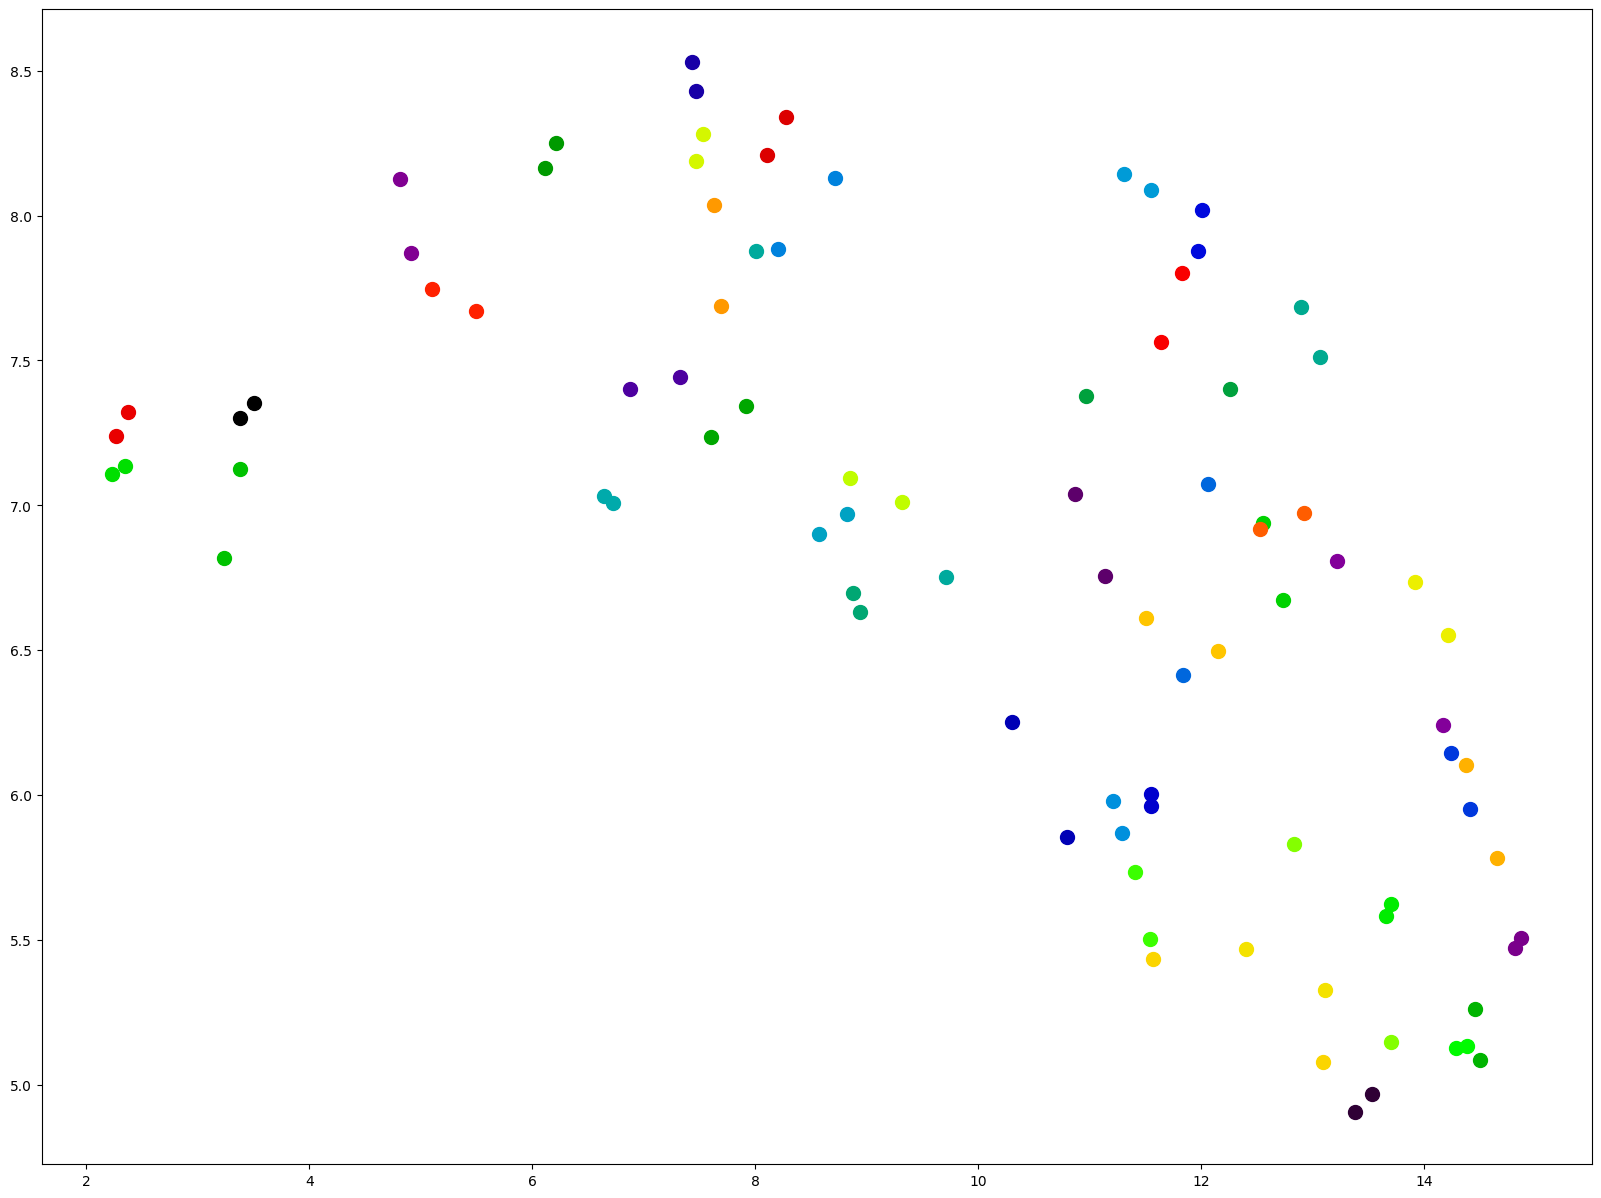

In [ ]:
label_set = np.unique(df_val['label'].values)
num_classes = len(label_set)
plt.figure(figsize=(20, 15))
plt.gca().set_prop_cycle(
    cycler(
        "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
    )
)
for i in range(num_classes):
  idx = df_train[df_train['label'] == label_set[i]].index.values
  #print(idx)
  plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=20)
plt.show()

<H3>Другие модели пока не проверял кром vits_16_dino  (смотрите modeltype)

In [ ]:
print(list(ViTExtractor.pretrained_models.keys()))

['vits16_dino', 'vits8_dino', 'vitb16_dino', 'vitb8_dino', 'vits16_inshop', 'vits16_sop', 'vits16_cub', 'vits16_cars']
